In [4]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Analysis of clusters in sample S1

In [5]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

In [6]:
import importlib

## Preprocessing
### Read data

In [9]:
data_path = "../../data/MOBA_scRNAseq/outs_S1"

data_gene = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed.h5ad")


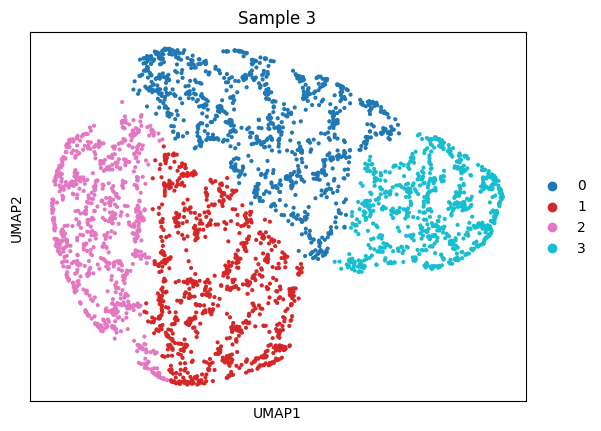

In [10]:
# sc.tl.leiden(data_gene, resolution=0.15, key_added="leiden_opt", random_state=1234)
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

## Initial DE testing: Wilcoxon rank-sum for every cluster against all others

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


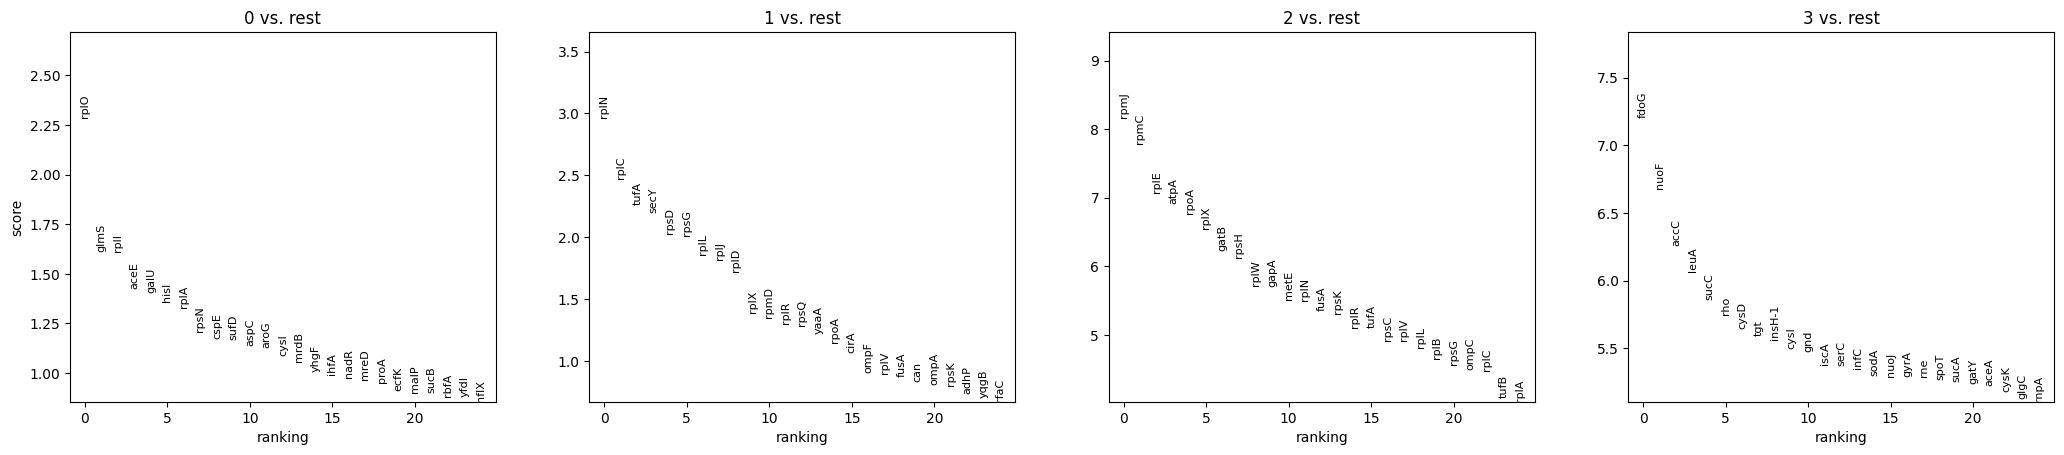

In [11]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [12]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 100
Both NB and ZINB not converged! Using NB without starting params
gene 200
gene 300
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 400
gene 500
Both NB and ZINB not converged! Using NB without starting params
gene 600
gene 700
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 800
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 900
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
ge

## Find optimal correlation matrix scaling and generate synthetic null data

In [14]:
importlib.reload(cd)
try:
    xmin, fval, R_est_noscale = cd.select_covariance_scaling(data_gene, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234)
except:
    _, R_est_noscale = cd.generate_nb_data_copula(data_gene, rng_seed=1234, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, corr_factor=1,
                                                  R_est=None, check_pd=True)
    xmin = 1
print(xmin)

Factor: 1 - Error: 0.0
Factor: 2 - Error: 0.0
Factor: 3.6180339999999998 - Error: 0.0
1


In [15]:
# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)


In [16]:
importlib.reload(cd)
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True,
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)

In [17]:
data_null_gen.var_names

Index(['aaeA', 'aaeB', 'aaeR', 'aaeX', 'aas', 'aat', 'abgA', 'abgB', 'abgR',
       'abgT',
       ...
       'zntR', 'znuA', 'znuB', 'znuC', 'zraP', 'zraR', 'zraS', 'zupT', 'zur',
       'zwf'],
      dtype='object', length=3851)

In [18]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [19]:
data_null_gen.var

,var_counts,mean_counts
aaeA,0.002357,0.002363
aaeB,0.000885,0.000886
aaeR,0.011122,0.010041
aaeX,0.001474,0.001477
aas,0.028637,0.024513
...,...,...
zraR,0.007910,0.007974
zraS,0.003531,0.003544
zupT,0.014339,0.011518
zur,0.009662,0.009155


In [20]:
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

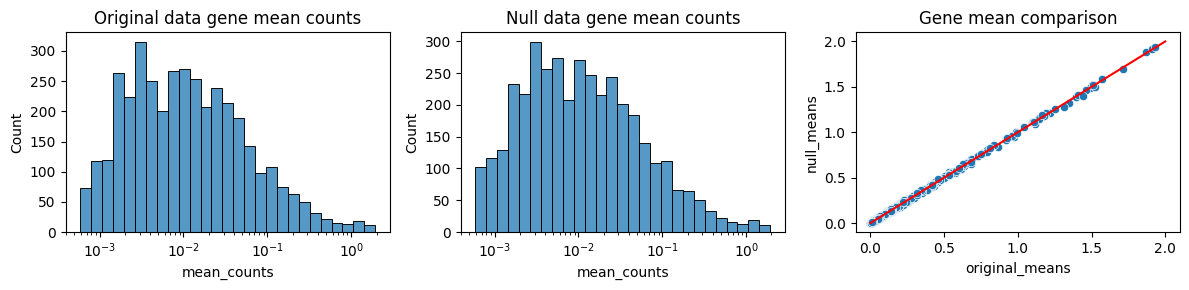

SignificanceResult(statistic=0.9844758663018501, pvalue=0.0)


In [21]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_nonzero.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

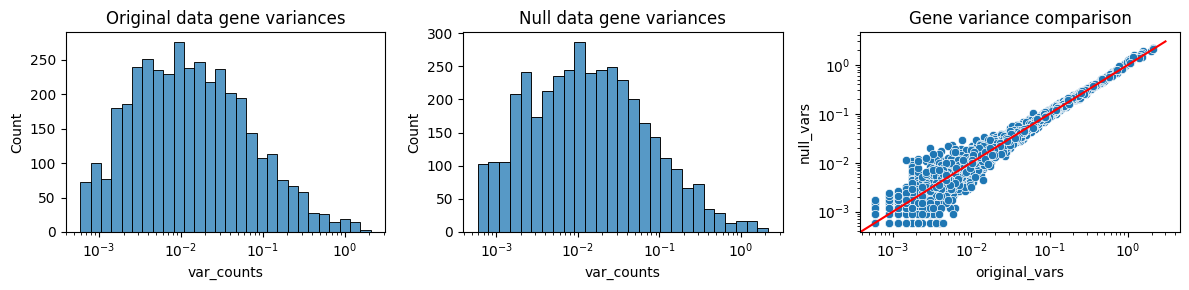

SignificanceResult(statistic=0.974493232013883, pvalue=0.0)
[[1.         0.99619464]
 [0.99619464 1.        ]]


In [22]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_nonzero.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

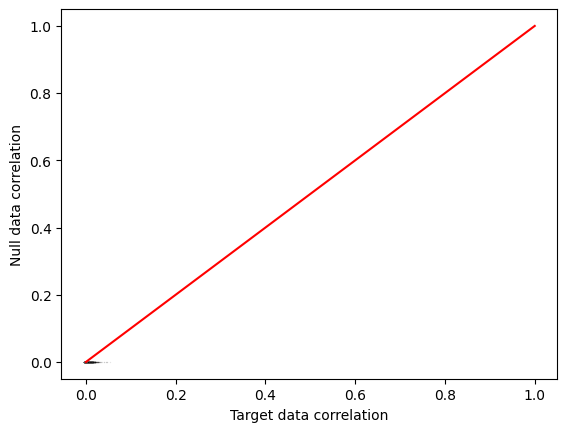

In [23]:
cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset['cor_shrink']))],
         color="red")
plt.xlabel("Target data correlation")
plt.ylabel("Null data correlation")

plt.show()

### Process null data

In [24]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [25]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform")
data_null_gen.layers["counts"] = data_null_gen.X.copy()

k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]
res_opt = data_gene.uns["BacSC_params"]["res_opt"]

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


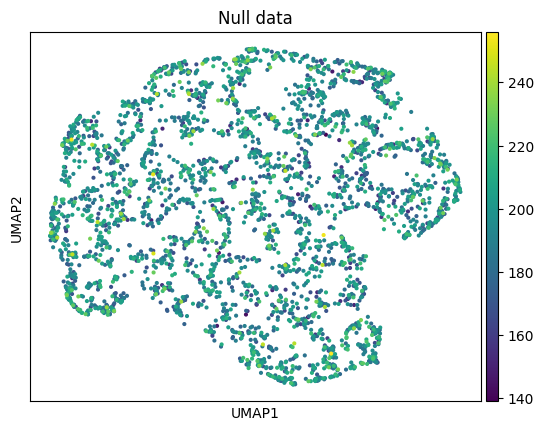

In [26]:
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()


In [27]:
data_null_gen.write(data_path + "/null_data_opt.h5ad")

In [ ]:
n_splits = 20
rng = np.random.default_rng(2345)
seeds = rng.choice(1000, n_splits)
null_pvals_dict = {}
min_pvals_null = []
c = 0
res_start = 0.01
res_step = 0.01

for s in seeds:
    res2 = res_start
    twoclust = False
    nclust = 1
    was_greater = False
    max_res_1_cluster = res_start
    
    while twoclust is False:
        if nclust < 2:
            if res2 > max_res_1_cluster:
                max_res_1_cluster = res2
            else: 
                res_step = res_step/2
            if was_greater:
                res2 += res_step
            else:
                res2 += 0.05
        else:
            was_greater = True
            min_res_2plus_clusters = res2
            res2 -= res_step
        res2 = np.round(res2, 3)
        sc.tl.leiden(data_null_gen, resolution=res2, key_added=f"leiden_{c}", random_state=s)
        nclust = len(data_null_gen.obs[f"leiden_{c}"].unique())
        if nclust == 2:
            twoclust = True
        print(f"resolution: {res2}, clusters: {nclust}")
            
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] == "0"]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] != "0"]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    null_pvals_dict[c] = null_pvals

    clusters = data_gene.obs["leiden_opt"].unique()
            
    min_pvals_null.append(np.min(null_pvals))
            
    print(f"split {c+1}/{n_splits} - Resolution {res2}")

    res_start = res2 - 0.05
    c += 1
    
best_split = np.where(min_pvals_null == np.max(min_pvals_null))[0][0]
print(best_split)
print(min_pvals_null[best_split])

In [ ]:
sc.pl.umap(data_null_gen, color=f"leiden_{best_split}", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [ ]:
importlib.reload(cd)
clusters = data_gene.obs["leiden_opt"].unique()
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    pvals_data = ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue
    p_data = pd.DataFrame({"pval_data": pvals_data}, index=data_gene_nonzero.var.index)
    pval_null_gen = pd.DataFrame({"pval_null": null_pvals_dict[best_split]}, index=data_null_gen.var.index)
    
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

In [ ]:
c = "1"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_trafo_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_trafo_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog", ylim=(0, 50))

sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (with log-transformation)")


plt.tight_layout()
plt.show()

In [ ]:
for c in clusters:
    print(f"cluster {c}")
    print(pvals_log_gen[c]["q"].value_counts().sort_index())
    print("")

In [ ]:
pvals_log_gen["0"]

In [ ]:
data_gene_nonzero.uns["ClusterDE_results"] = pvals_log_gen

data_gene_nonzero.uns["ClusterDE_results"]['params'] = {'groupby': 'leiden_opt',
  'reference': 'rest',
  'use_raw': False,
  'layer': None,
}

In [ ]:
data_gene_nonzero.write(data_path + "/filtered_data_maxpool_processed_cluster.h5ad")

In [ ]:
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:10,:].index.tolist()
    data_gene_nonzero.obs["is_c"] = pd.Categorical([x==c for x in data_gene_nonzero.obs["leiden_opt"]])
    with plt.rc_context({"figure.figsize": (5, 5)}):
        sc.pl.violin(data_gene_nonzero, keys=plot_genes, groupby="is_c", multi_panel=True)

In [ ]:
data_gene.var

In [ ]:
n_genes = 10
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    sc.pl.rank_genes_groups_violin(data_gene_nonzero, gene_names=plot_genes, key="ClusterDE_results", groups=c)

In [ ]:
all_marker_genes = []
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    all_marker_genes += plot_genes
    print(f"Cluster {c}")
    print(data_gene.var.loc[plot_genes, ["Locus tag", "Name", "Symbol"]])

In [ ]:
sc.pl.heatmap(data_gene_nonzero, all_marker_genes, groupby='leiden_opt', swap_axes=True)